# DEAM Dataset - Feed Forward Neural Network
## Essentia Best Overall & openSMILE ComParE2016 Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_deam_path('processed/annotations/deam_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,2,-0.475,-0.500
1,3,-0.375,-0.425
2,4,0.175,0.125
3,5,-0.150,0.075
4,7,0.200,0.350
...,...,...,...
1739,1996,-0.275,0.225
1740,1997,0.075,-0.275
1741,1998,0.350,0.300
1742,1999,-0.100,0.100


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_overall_opensmile_compare2016_features = pd.read_csv(get_deam_path('processed/features/integrated/standardised_essentia_best_overall_opensmile_compare2016_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_opensmile_compare2016_features = df_essentia_best_overall_opensmile_compare2016_features[df_essentia_best_overall_opensmile_compare2016_features.columns[1:]]

df_essentia_best_overall_opensmile_compare2016_features

,song_id,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,2,-0.092381,-0.078572,-0.025137,-0.024931,-0.051278,-0.058571,-0.055109,0.361562,-0.018698,...,-0.631867,-0.365685,-0.279802,-0.282638,1.033912,1.253936,0.258343,-0.101681,0.267050,-0.103648
1,3,0.073364,0.050761,-0.025077,-0.024890,-0.020349,1.479718,3.014248,0.583826,0.056605,...,-0.952109,-1.043699,-0.949817,-0.947268,-0.967357,0.042120,-1.127785,-0.883942,-1.084239,-0.561874
2,4,-0.119333,-0.107505,-0.025174,-0.024965,-0.083147,-0.208423,-0.075820,0.053745,-0.094185,...,-0.252214,-0.788912,-0.139047,-0.140901,1.033912,0.889151,-0.026883,0.089203,-0.241184,-0.576476
3,5,-0.163481,-0.139436,-0.025195,-0.024978,-0.094325,-0.262338,-0.148097,-0.493194,-0.110313,...,-0.484816,-1.100697,-0.386997,-0.392154,1.033909,0.387215,-0.513832,-0.330955,-0.729651,-0.400833
4,7,0.721637,0.521923,-0.024526,-0.024479,0.015265,2.154544,4.094221,0.492728,0.184390,...,-0.679149,0.063000,-1.232202,-1.229221,-0.967357,0.368769,-1.143719,-1.322279,-1.174207,-1.294879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1996,-0.154993,-0.129360,-0.025193,-0.024975,-0.100449,-0.321333,-0.138527,0.145668,-0.130138,...,-0.774443,0.503124,-0.529866,-0.535381,1.033905,-0.030763,-0.263638,-0.737909,0.002047,-0.727175
1740,1997,-0.169892,-0.137550,-0.025197,-0.024978,-0.102115,-0.346532,-0.290196,-0.205395,-0.126981,...,-0.029122,-0.435924,-0.013004,-0.020709,1.033884,-0.033798,0.353010,0.525906,0.453648,0.424850
1741,1998,-0.106021,-0.088136,-0.025128,-0.024919,-0.035307,-0.242062,-0.115127,-0.427167,-0.093478,...,-0.697061,1.159923,-0.806402,-0.809586,1.033912,-0.252968,-0.728777,-1.008194,-0.453289,-0.757926
1742,1999,-0.124002,-0.105158,-0.025185,-0.024971,-0.068508,-0.098127,0.316466,1.586562,-0.104839,...,-0.391407,1.480851,-0.725574,-0.727505,1.033912,-0.852857,-0.127534,-0.522571,-0.095621,-0.490813


In [4]:
df_essentia_best_overall_opensmile_compare2016_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 6510 columns):
 #     Column                                                    Dtype  
---    ------                                                    -----  
 0     song_id                                                   int64  
 1     lowlevel.melbands_kurtosis.dmean                          float64
 2     lowlevel.melbands_kurtosis.dmean2                         float64
 3     lowlevel.melbands_kurtosis.dvar                           float64
 4     lowlevel.melbands_kurtosis.dvar2                          float64
 5     lowlevel.melbands_kurtosis.max                            float64
 6     lowlevel.melbands_kurtosis.mean                           float64
 7     lowlevel.melbands_kurtosis.median                         float64
 8     lowlevel.melbands_kurtosis.min                            float64
 9     lowlevel.melbands_kurtosis.stdev                          float64
 10    lowlevel

Join both the featureset and annotation set together

In [5]:
df_essentia_best_overall_opensmile_compare2016_whole = pd.merge(df_essentia_best_overall_opensmile_compare2016_features, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_opensmile_compare2016_whole = df_essentia_best_overall_opensmile_compare2016_whole.drop('song_id', axis=1)
df_essentia_best_overall_opensmile_compare2016_whole

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,valence_mean_mapped,arousal_mean_mapped
0,-0.092381,-0.078572,-0.025137,-0.024931,-0.051278,-0.058571,-0.055109,0.361562,-0.018698,-0.026304,...,-0.279802,-0.282638,1.033912,1.253936,0.258343,-0.101681,0.267050,-0.103648,-0.475,-0.500
1,0.073364,0.050761,-0.025077,-0.024890,-0.020349,1.479718,3.014248,0.583826,0.056605,-0.025526,...,-0.949817,-0.947268,-0.967357,0.042120,-1.127785,-0.883942,-1.084239,-0.561874,-0.375,-0.425
2,-0.119333,-0.107505,-0.025174,-0.024965,-0.083147,-0.208423,-0.075820,0.053745,-0.094185,-0.026786,...,-0.139047,-0.140901,1.033912,0.889151,-0.026883,0.089203,-0.241184,-0.576476,0.175,0.125
3,-0.163481,-0.139436,-0.025195,-0.024978,-0.094325,-0.262338,-0.148097,-0.493194,-0.110313,-0.026850,...,-0.386997,-0.392154,1.033909,0.387215,-0.513832,-0.330955,-0.729651,-0.400833,-0.150,0.075
4,0.721637,0.521923,-0.024526,-0.024479,0.015265,2.154544,4.094221,0.492728,0.184390,-0.023528,...,-1.232202,-1.229221,-0.967357,0.368769,-1.143719,-1.322279,-1.174207,-1.294879,0.200,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,-0.154993,-0.129360,-0.025193,-0.024975,-0.100449,-0.321333,-0.138527,0.145668,-0.130138,-0.026911,...,-0.529866,-0.535381,1.033905,-0.030763,-0.263638,-0.737909,0.002047,-0.727175,-0.275,0.225
1740,-0.169892,-0.137550,-0.025197,-0.024978,-0.102115,-0.346532,-0.290196,-0.205395,-0.126981,-0.026903,...,-0.013004,-0.020709,1.033884,-0.033798,0.353010,0.525906,0.453648,0.424850,0.075,-0.275
1741,-0.106021,-0.088136,-0.025128,-0.024919,-0.035307,-0.242062,-0.115127,-0.427167,-0.093478,-0.026783,...,-0.806402,-0.809586,1.033912,-0.252968,-0.728777,-1.008194,-0.453289,-0.757926,0.350,0.300
1742,-0.124002,-0.105158,-0.025185,-0.024971,-0.068508,-0.098127,0.316466,1.586562,-0.104839,-0.026830,...,-0.725574,-0.727505,1.033912,-0.852857,-0.127534,-0.522571,-0.095621,-0.490813,-0.100,0.100


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_overall_opensmile_compare2016_features.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.dmean,lowlevel.melbands_kurtosis.dmean2,lowlevel.melbands_kurtosis.dvar,lowlevel.melbands_kurtosis.dvar2,lowlevel.melbands_kurtosis.max,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_kurtosis.median,lowlevel.melbands_kurtosis.min,lowlevel.melbands_kurtosis.stdev,lowlevel.melbands_kurtosis.var,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,-0.092381,-0.078572,-0.025137,-0.024931,-0.051278,-0.058571,-0.055109,0.361562,-0.018698,-0.026304,...,-0.631867,-0.365685,-0.279802,-0.282638,1.033912,1.253936,0.258343,-0.101681,0.267050,-0.103648
1,0.073364,0.050761,-0.025077,-0.024890,-0.020349,1.479718,3.014248,0.583826,0.056605,-0.025526,...,-0.952109,-1.043699,-0.949817,-0.947268,-0.967357,0.042120,-1.127785,-0.883942,-1.084239,-0.561874
2,-0.119333,-0.107505,-0.025174,-0.024965,-0.083147,-0.208423,-0.075820,0.053745,-0.094185,-0.026786,...,-0.252214,-0.788912,-0.139047,-0.140901,1.033912,0.889151,-0.026883,0.089203,-0.241184,-0.576476
3,-0.163481,-0.139436,-0.025195,-0.024978,-0.094325,-0.262338,-0.148097,-0.493194,-0.110313,-0.026850,...,-0.484816,-1.100697,-0.386997,-0.392154,1.033909,0.387215,-0.513832,-0.330955,-0.729651,-0.400833
4,0.721637,0.521923,-0.024526,-0.024479,0.015265,2.154544,4.094221,0.492728,0.184390,-0.023528,...,-0.679149,0.063000,-1.232202,-1.229221,-0.967357,0.368769,-1.143719,-1.322279,-1.174207,-1.294879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,-0.154993,-0.129360,-0.025193,-0.024975,-0.100449,-0.321333,-0.138527,0.145668,-0.130138,-0.026911,...,-0.774443,0.503124,-0.529866,-0.535381,1.033905,-0.030763,-0.263638,-0.737909,0.002047,-0.727175
1740,-0.169892,-0.137550,-0.025197,-0.024978,-0.102115,-0.346532,-0.290196,-0.205395,-0.126981,-0.026903,...,-0.029122,-0.435924,-0.013004,-0.020709,1.033884,-0.033798,0.353010,0.525906,0.453648,0.424850
1741,-0.106021,-0.088136,-0.025128,-0.024919,-0.035307,-0.242062,-0.115127,-0.427167,-0.093478,-0.026783,...,-0.697061,1.159923,-0.806402,-0.809586,1.033912,-0.252968,-0.728777,-1.008194,-0.453289,-0.757926
1742,-0.124002,-0.105158,-0.025185,-0.024971,-0.068508,-0.098127,0.316466,1.586562,-0.104839,-0.026830,...,-0.391407,1.480851,-0.725574,-0.727505,1.033912,-0.852857,-0.127534,-0.522571,-0.095621,-0.490813


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
1739,-0.275,0.225
1740,0.075,-0.275
1741,0.350,0.300
1742,-0.100,0.100


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()
num_epochs = 300

Define the neural network

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [13]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([1395, 6509])


Training loop

In [14]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [15]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.5615356709350147
Epoch 2, Loss: 0.5585986584000913
Epoch 3, Loss: 0.5567499421508924
Epoch 4, Loss: 0.5553389203039372
Epoch 5, Loss: 0.5533543806161688
Epoch 6, Loss: 0.5491356581971965
Epoch 7, Loss: 0.5396943190540888
Epoch 8, Loss: 0.523130611585556
Epoch 9, Loss: 0.5262368063733901
Epoch 10, Loss: 0.5079375186496308
Epoch 11, Loss: 0.5043235647642612
Epoch 12, Loss: 0.5004516290409292
Epoch 13, Loss: 0.4913798017313312
Epoch 14, Loss: 0.47648085223070163
Epoch 15, Loss: 0.46350722952948165
Epoch 16, Loss: 0.4598266988814663
Epoch 17, Loss: 0.4595945644505026
Epoch 18, Loss: 0.4497882053206135
Epoch 19, Loss: 0.4535230663914626
Epoch 20, Loss: 0.44634628763741435
Epoch 21, Loss: 0.4419037370091693
Epoch 22, Loss: 0.43932422018922423
Epoch 23, Loss: 0.4365305035934495
Epoch 24, Loss: 0.43173209899741993
Epoch 25, Loss: 0.42857348208843715
Epoch 26, Loss: 0.4266319875047138
Epoch 27, Loss: 0.423965923919335
Epoch 28, Loss: 0.42066935170798386
Epoch 29, Loss: 0.418424

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [16]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([349, 6509])


Generating scores

In [17]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute().item()
  print(f'Test R^2 score: {r2_score}')
  return test_pred, rmse, r2_score

In [18]:
test_pred, rmse, r2_score = test_model(model)

Test RMSE: 0.19105348252788043
Test R^2 score: 0.6023322706766878


True values (test set)

In [19]:
target_test_labels

tensor([[-0.1500, -0.1500],
        [-0.3000, -0.1000],
        [ 0.2000,  0.3500],
        [ 0.2250,  0.4500],
        [-0.1750, -0.2000],
        [-0.5250, -0.3000],
        [-0.2500, -0.7750],
        [ 0.3000,  0.3000],
        [-0.1750, -0.4000],
        [ 0.4500,  0.1500],
        [ 0.1750,  0.0250],
        [-0.1750, -0.0250],
        [-0.0500, -0.3000],
        [ 0.1250,  0.3000],
        [-0.0750, -0.1500],
        [-0.2000, -0.2750],
        [-0.6000, -0.2250],
        [ 0.1500, -0.2000],
        [ 0.2750,  0.6000],
        [-0.1500, -0.4500],
        [-0.2250, -0.6250],
        [-0.0250, -0.4500],
        [-0.5250, -0.1250],
        [ 0.0000,  0.3250],
        [ 0.1250,  0.3750],
        [ 0.1500, -0.2500],
        [ 0.4500,  0.3250],
        [ 0.2500,  0.2250],
        [-0.1000,  0.0750],
        [ 0.4250,  0.1250],
        [-0.4500, -0.3500],
        [-0.0500,  0.3750],
        [-0.4750, -0.2000],
        [-0.2750, -0.4000],
        [-0.4000, -0.2250],
        [ 0.1000, -0

Predicted values

In [20]:
test_pred

tensor([[ 1.3422e-01,  4.4651e-02],
        [-2.9996e-01, -1.4356e-01],
        [ 4.4730e-01,  3.4847e-01],
        [ 2.0878e-01,  4.2403e-01],
        [-1.6580e-01, -2.8831e-01],
        [-4.0506e-01, -1.8295e-01],
        [-3.0080e-01, -5.7953e-01],
        [ 3.1406e-01,  3.5043e-01],
        [-2.8113e-01, -3.5703e-01],
        [ 3.4916e-01,  3.4988e-01],
        [ 2.8205e-01,  1.2146e-01],
        [-3.5086e-01, -1.4948e-01],
        [ 5.5347e-02, -2.2420e-01],
        [ 1.3258e-01,  1.9052e-01],
        [ 8.6008e-03, -2.6079e-02],
        [-3.3300e-01, -3.7884e-01],
        [-5.2378e-01, -1.9581e-01],
        [-3.8195e-02, -2.8331e-01],
        [ 1.3559e-01,  3.9356e-01],
        [-1.1903e-01, -2.2052e-01],
        [-4.3740e-01, -3.7093e-01],
        [-3.3363e-01, -3.7050e-01],
        [-5.3706e-01, -4.2421e-01],
        [ 2.2966e-01,  3.8247e-01],
        [ 4.9088e-02,  2.9934e-01],
        [ 2.9912e-01,  6.6103e-02],
        [ 4.5572e-01,  3.6859e-01],
        [ 2.2299e-01,  9.797

## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [21]:
num_epochs_list = [i for i in range(1, 301)]
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [22]:
for num_epochs in num_epochs_list:
  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, r2_score = test_model(model)
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.5622485446495533
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30897011504904104
Test R^2 score: -0.04241297436125169
Num of epochs: 2
Epoch 1, Loss: 0.5562595870231237
Epoch 2, Loss: 0.5563567391327585
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30272581086548533
Test R^2 score: 0.0012992681785974902
Num of epochs: 3
Epoch 1, Loss: 0.5581825717054527
Epoch 2, Loss: 0.5565824244004833
Epoch 3, Loss: 0.5558461459121029
Training completed.
Training completed.
Testing model...
Test RMSE: 0.30252933109880237
Test R^2 score: 0.0017172437384639916
Num of epochs: 4
Epoch 1, Loss: 0.5594663140551214
Epoch 2, Loss: 0.5573032383890898
Epoch 3, Loss: 0.5560799703152857
Epoch 4, Loss: 0.5551613140653633
Training completed.
Training completed.
Testing model...
Test RMSE: 0.2992013901761164
Test R^2 score: 0.02432488123198412
Num of epochs: 5
Epoch 1, Loss: 0.5564060185257073
Epoch 2, Loss: 0.5562393616076926
Epoch 3

### Plot the graph to visualise the relationship between epochs and r^2 score

Import relevant libraries

In [23]:
import matplotlib.pyplot as plt

In [24]:
r2_scores_list

[-0.04241297436125169,
 0.0012992681785974902,
 0.0017172437384639916,
 0.02432488123198412,
 0.04894386359311875,
 0.08712166406363092,
 0.2334555313448578,
 0.2229789651189653,
 0.42516493791116755,
 0.36500782448586677,
 0.3877144443540767,
 0.31424291146374744,
 0.4565638252793975,
 0.45599226437324,
 0.478552570933322,
 0.47306035486166553,
 0.4459897288032798,
 0.5033710340163929,
 0.5235222828355832,
 0.5220136792188708,
 0.5270713151526145,
 0.5103569495916325,
 0.5477701520628893,
 0.5063139548708379,
 0.5322279329546644,
 0.5683414939308011,
 0.5143021526954266,
 0.541203324048349,
 0.5618206711477597,
 0.5414548593867715,
 0.5620294071684576,
 0.5645346411609293,
 0.5434773107060249,
 0.5605869822191364,
 0.5718713643521911,
 0.5630040631520851,
 0.521259572346888,
 0.5828586740669037,
 0.5484775881337487,
 0.5737008588289935,
 0.5371725831287244,
 0.6000701798641764,
 0.5717826952296101,
 0.5531257063953785,
 0.576459662606954,
 0.6124763304345319,
 0.5975934683511156,
 0.5

Plot the line graph

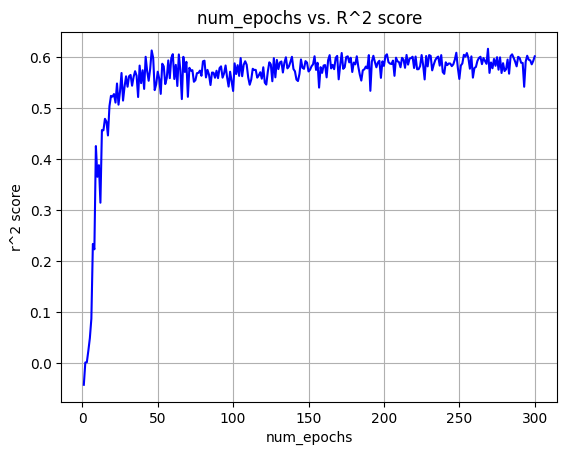

In [25]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. R^2 score')
plt.xlabel('num_epochs')
plt.ylabel('r^2 score') 
plt.grid(True)
plt.show() 

In [26]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.6157626118623329
Corresponding RMSE: 0.18762039264361408
Corresponding num_epochs: 269
